# TransferMarkt Data Warehouse - ETL & Benchmark Project

**Platform**: Databricks Serverless + Unity Catalog  
**Dataset**: TransferMarkt Football Analytics

---

## Table of Contents
1. Setup & Data Ingestion
2. ETL: Star Schema Transformation
3. Write Performance Benchmarking
4. Read Performance Benchmarking
5. Analysis & Visualizations
6. Final Report

---
# 1. Setup & Data Ingestion

## 1.1 Install Dependencies

In [0]:
%pip install kagglehub tabulate matplotlib seaborn --quiet
dbutils.library.restartPython()

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


## 1.2 Import Libraries

In [0]:
# Core libraries
import kagglehub
import shutil
import os
import time
import tempfile
import builtins
import traceback
from datetime import datetime

# Spark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Data analysis & visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Create Unity Catalog Structure

In [0]:
%sql
-- Create catalog and schema
CREATE CATALOG IF NOT EXISTS main;
CREATE SCHEMA IF NOT EXISTS main.transfermarkt;

-- Create volumes
CREATE VOLUME IF NOT EXISTS main.transfermarkt.raw_data;
CREATE VOLUME IF NOT EXISTS main.transfermarkt.benchmark_csv;
CREATE VOLUME IF NOT EXISTS main.transfermarkt.benchmark_avro;
CREATE VOLUME IF NOT EXISTS main.transfermarkt.benchmark_parquet;
CREATE VOLUME IF NOT EXISTS main.transfermarkt.benchmark_metrics;
CREATE VOLUME IF NOT EXISTS main.transfermarkt.reports;

## 1.4 Download Dataset from Kaggle

In [0]:
# Download to temp location
path = kagglehub.dataset_download("davidcariboo/player-scores")

# Copy to Unity Catalog volume
unity_catalog_path = "/Volumes/main/transfermarkt/raw_data/"
os.makedirs(unity_catalog_path, exist_ok=True)

# Copy CSV files
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
total_size = builtins.sum(os.path.getsize(os.path.join(path, f)) for f in csv_files) / 1024**2

for filename in csv_files:
    shutil.copy2(os.path.join(path, filename), os.path.join(unity_catalog_path, filename))

print(f"Downloaded {len(csv_files)} files ({total_size:.2f} MB)")

100%|██████████| 165M/165M [00:00<00:00, 184MB/s]

Extracting files...


Downloaded 10 files (530.08 MB)


---
# 2. ETL: Star Schema Transformation 

## 2.1 Define Paths & Helper Functions

In [0]:
# Define paths
raw_data_path = "/Volumes/main/transfermarkt/raw_data/"

def read_source_csv(filename):
    """Read CSV from Unity Catalog"""
    df = spark.read.csv(f"{raw_data_path}{filename}", header=True, inferSchema=True)
    return df

## 2.2 Transform Dimension Tables

In [0]:
# Load source data
players_df = read_source_csv("players.csv")
clubs_df = read_source_csv("clubs.csv")
competitions_df = read_source_csv("competitions.csv")
games_df = read_source_csv("games.csv")

In [0]:
# dim_player
dim_player = players_df.select(
    col("player_id").cast("int"),
    col("first_name"),
    col("last_name"), 
    col("name"), 
    col("player_code"),
    col("country_of_birth"), 
    col("city_of_birth"), 
    col("country_of_citizenship"),
    col("date_of_birth").cast("timestamp"),
    col("position"), 
    col("sub_position"), 
    col("foot"),
    col("height_in_cm").cast("int"), 
    col("agent_name"), 
    col("image_url"), 
    col("url")
).dropDuplicates(["player_id"])

# dim_club 
dim_club = clubs_df.select(
    col("club_id").cast("int"),
    col("club_code"), 
    col("name"),
    col("domestic_competition_id"),
    col("stadium_name"),
    col("stadium_seats").cast("int"),
    col("url")
).dropDuplicates(["club_id"]).alias("clubs").join(
    competitions_df.select(
        col("competition_id"),
        col("name").alias("domestic_competition_name")
    ).alias("comps"),
    col("clubs.domestic_competition_id") == col("comps.competition_id"),  
    "left"
).select("clubs.*", "comps.domestic_competition_name") 

# dim_competition
dim_competition = competitions_df.select(
    col("competition_id"), col("competition_code"), col("name"),
    col("sub_type"), col("type"), col("country_id").cast("int"),
    col("country_name"), col("domestic_league_code"), col("confederation"),
    col("url"), col("is_major_national_league").cast("boolean")
).dropDuplicates(["competition_id"])

# dim_game_details
dim_game_details = games_df.select(
    col("game_id").cast("int"), col("season").cast("int"), col("round"),
    col("date").cast("date"), col("stadium"), col("referee"),
    col("home_club_manager_name"), col("away_club_manager_name"),
    col("aggregate"), col("competition_type"), col("url"),
    col("home_club_formation"), col("away_club_formation")
).dropDuplicates(["game_id"])

## 2.3 Transform Fact Tables

In [0]:
# Load additional source data
appearances_df = read_source_csv("appearances.csv")
club_games_df = read_source_csv("club_games.csv")
game_events_df = read_source_csv("game_events.csv")
player_valuations_df = read_source_csv("player_valuations.csv")
transfers_df = read_source_csv("transfers.csv")

# fact_games
fact_games = games_df.select(
    col("game_id").cast("int"), col("competition_id"), col("date").cast("date"),
    col("home_club_id").cast("int"), col("away_club_id").cast("int"),
    col("home_club_goals").cast("int"), col("away_club_goals").cast("int"),
    col("home_club_position").cast("int"), col("away_club_position").cast("int"),
    col("attendance").cast("int")
).dropDuplicates(["game_id"])

# fact_appearances
fact_appearances = appearances_df.select(
    col("appearance_id"), col("game_id").cast("int"), col("player_id").cast("int"),
    col("player_club_id").cast("int"), col("player_current_club_id").cast("int"),
    col("date").cast("date"), col("competition_id"),
    col("yellow_cards").cast("int"), col("red_cards").cast("int"),
    col("goals").cast("int"), col("assists").cast("int"), col("minutes_played").cast("int")
)

# fact_club_games
fact_club_games = club_games_df.select(
    col("game_id").cast("int"), col("club_id").cast("int"), col("opponent_id").cast("int"),
    col("own_goals").cast("int"), col("own_position").cast("int"),
    col("opponent_goals").cast("int"), col("opponent_position").cast("int"),
    col("is_win").cast("boolean"), col("own_manager_name"),
    col("opponent_manager_name"), col("hosting")
)

# fact_game_events
fact_game_events = game_events_df.select(
    col("game_event_id"), col("date").cast("date"), col("game_id").cast("int"),
    col("player_id").cast("int"), col("club_id").cast("int"),
    col("player_in_id").cast("int"), col("player_assist_id").cast("int"),
    col("minute").cast("int"), col("type"), col("description")
)

# fact_player_valuations
fact_player_valuations = player_valuations_df.select(
    col("player_id").cast("int"), col("date").cast("date"),
    col("current_club_id").cast("int"), col("player_club_domestic_competition_id"),
    col("market_value_in_eur").cast("decimal(18,2)")
)

# fact_transfers
fact_transfers = transfers_df.select(
    col("player_id").cast("int"), col("transfer_date").cast("date"),
    col("from_club_id").cast("int"), col("to_club_id").cast("int"),
    col("transfer_season"), col("transfer_fee").cast("decimal(18,2)"),
    col("market_value_in_eur").cast("decimal(18,2)")
)

# fact_club_snapshot
fact_club_snapshot = clubs_df.select(
    col("club_id").cast("int"),
    concat(col("last_season").cast("string"), lit("-12-31")).cast("date").alias("snapshot_date"),
    col("total_market_value").cast("decimal(18,2)"), col("squad_size").cast("int"),
    col("average_age").cast("decimal(5,2)"), col("foreigners_number").cast("int"),
    col("foreigners_percentage").cast("decimal(5,2)"), col("national_team_players").cast("int"),
    col("net_transfer_record"), col("coach_name")
)


## 2.4 Store Transformed Tables

In [0]:
# Store all tables
tables = {
    'dim_player': dim_player,
    'dim_club': dim_club,
    'dim_competition': dim_competition,
    'dim_game_details': dim_game_details,
    'fact_games': fact_games,
    'fact_appearances': fact_appearances,
    'fact_club_games': fact_club_games,
    'fact_game_events': fact_game_events,
    'fact_player_valuations': fact_player_valuations,
    'fact_transfers': fact_transfers,
    'fact_club_snapshot': fact_club_snapshot
}

# Create summary
summary = pd.DataFrame([
    {'Table': name, 'Type': 'Dimension' if name.startswith('dim_') else 'Fact',
     'Rows': df.count(), 'Columns': len(df.columns)}
    for name, df in tables.items()
])

print("ETL Complete - Star Schema Created")
display(summary)

ETL Complete - Star Schema Created


Table,Type,Rows,Columns
dim_player,Dimension,32601,16
dim_club,Dimension,439,8
dim_competition,Dimension,44,11
dim_game_details,Dimension,74026,13
fact_games,Fact,74026,10
fact_appearances,Fact,1706806,12
fact_club_games,Fact,148052,11
fact_game_events,Fact,1035043,10
fact_player_valuations,Fact,496606,5
fact_transfers,Fact,79646,7


---
# 3. Write Performance Benchmarking

## 3.1 Define Benchmark Functions

In [0]:
write_metrics = []

def benchmark_write(df, table_name, format_type, compression=None):
    """Benchmark write performance"""
    
    # Build path
    base = f"/Volumes/main/transfermarkt/benchmark_{format_type}/"
    if compression:
        path = f"{base}{compression}/{table_name}"
    else:
        path = f"{base}uncompressed/{table_name}"
    
    # Remove if exists
    try:
        dbutils.fs.rm(path, recurse=True)
    except Exception as ex:
        print(f"Warning: Could not remove {path}: {ex}")
    
    # Measure write
    start = time.time()
    
    try:
        writer = df.write.mode("overwrite")
        if compression and format_type != 'csv':
            writer = writer.option("compression", compression)
        
        if format_type == 'csv':
            writer.csv(path, header=True)
        elif format_type == 'avro':
            writer.format("avro").save(path)
        else:
            writer.parquet(path)
        
        duration = time.time() - start
        
        # Get size
        files = dbutils.fs.ls(path)
        size = builtins.sum(f.size for f in files if not f.name.startswith('_'))
        size_mb = size / 1048576.0
        print(f"{table_name}: successfully wrote {size_mb} MB in {duration} seconds")
        # Store metrics
        write_metrics.append({
            'table': table_name,
            'format': format_type,
            'compression': compression or 'none',
            'rows': df.count(),
            'size_mb': builtins.round(size_mb, 2),
            'write_time_seconds': builtins.round(duration, 3),
            'status': 'success'
        })
        return True
        
    except Exception as e:
        import traceback
        error_msg = str(e) if str(e) else traceback.format_exc()
        print(f"Error writing {table_name}: {error_msg}")
        write_metrics.append({
            'table': table_name,
            'format': format_type,
            'compression': compression or 'none',
            'status': 'failed',
            'error': error_msg
        })
        return False

## 3.2 Run Write Benchmarks

In [0]:
# Test CSV
for tname, df in tables.items():
    benchmark_write(df, tname, 'csv')

# Test Avro
for comp in [None, 'snappy', 'deflate', 'bzip2']:
    for tname, df in tables.items():
        benchmark_write(df, tname, 'avro', comp)

# Test Parquet
for comp in [None, 'snappy', 'gzip', 'lz4', 'zstd']:
    for tname, df in tables.items():
        benchmark_write(df, tname, 'parquet', comp)

# Save metrics - THE ONLY FIX YOU NEEDED
successful = [m for m in write_metrics if m['status'] == 'success']

# Check if list is empty before creating DataFrame
if len(successful) > 0:
    write_df = spark.createDataFrame(successful)
    write_df.write.mode("overwrite").parquet("/Volumes/main/transfermarkt/benchmark_metrics/write_metrics.parquet")
    print(f"Write benchmarks complete ({len(successful)}/{len(write_metrics)} successful)")
else:
    print(f"All {len(write_metrics)} benchmarks failed! Check your tables.")
    # Show first few errors
    failed = [m for m in write_metrics if m['status'] == 'failed']
    for m in failed[:3]:
        print(f"   {m['table']} ({m['format']}/{m['compression']}): {m['error']}")

dim_player: successfully wrote 8.979216575622559 MB in 1.4302783012390137 seconds
dim_club: successfully wrote 0.0638132095336914 MB in 1.0964546203613281 seconds
dim_competition: successfully wrote 0.007130622863769531 MB in 1.0234196186065674 seconds
dim_game_details: successfully wrote 17.275775909423828 MB in 1.3331494331359863 seconds
fact_games: successfully wrote 3.173025131225586 MB in 1.1590631008148193 seconds
fact_appearances: successfully wrote 103.88739395141602 MB in 2.267366886138916 seconds
fact_club_games: successfully wrote 9.25233268737793 MB in 1.8758692741394043 seconds
fact_game_events: successfully wrote 106.58033561706543 MB in 3.6731419563293457 seconds
fact_player_valuations: successfully wrote 17.235475540161133 MB in 2.1265602111816406 seconds
fact_transfers: successfully wrote 3.4237241744995117 MB in 1.9503295421600342 seconds
fact_club_snapshot: successfully wrote 0.018978118896484375 MB in 1.760972023010254 seconds
dim_player: successfully wrote 3.342495

---
# 4. Read Performance Benchmarking

## 4.1 Define Read Benchmark Functions

In [0]:
read_metrics = []

def benchmark_read(table_name, format_type, compression=None, query_type='full_scan'):
    """Benchmark read performance"""
    
    # Build path
    base = f"/Volumes/main/transfermarkt/benchmark_{format_type}/"
    comp_dir = compression or "uncompressed"
    path = f"{base}{comp_dir}/{table_name}"
    
    start = time.time()
    
    try:
        # Read
        if format_type == 'csv':
            df = spark.read.csv(path, header=True, inferSchema=True)
        elif format_type == 'avro':
            df = spark.read.format("avro").load(path)
        else:
            df = spark.read.parquet(path)
        
        # Query
        if query_type == 'selective_columns':
            result = df.select(*df.columns[:3]).count()
        else:
            result = df.count()
        
        duration = time.time() - start
        
        # Store metrics
        print(f"Read {table_name} success in {format_type}/{compression}): {duration} seconds")
        read_metrics.append({
            'table': table_name,
            'format': format_type,
            'compression': compression or 'none',
            'query_type': query_type,
            'rows_read': result,
            'read_time_seconds': builtins.round(duration, 3),
            'status': 'success'
        })
        return True
    except:
        print(f"Error reading {table_name}: {traceback.format_exc()}")
        
        read_metrics.append({
            'table': table_name,
            'format': format_type,
            'compression': compression or 'none',
            'query_type': query_type,
            'status': 'failed'
        })
        return False



## 4.2 Run Read Benchmarks

In [0]:
# Test CSV
for tname in tables:
    benchmark_read(tname, 'csv')

# Test Avro
for comp in [None, 'snappy', 'deflate', 'bzip2']:
    for tname in tables:
        benchmark_read(tname, 'avro', comp)

# Test Parquet
for comp in [None, 'snappy', 'gzip', 'lz4', 'zstd']:
    for tname in tables:
        benchmark_read(tname, 'parquet', comp)

# Test selective columns on large tables
for tname in ['fact_appearances', 'fact_player_valuations', 'fact_game_events']:
    benchmark_read(tname, 'parquet', 'snappy', 'selective_columns')
    benchmark_read(tname, 'csv', None, 'selective_columns')

# Save metrics
successful_reads = [m for m in read_metrics if m['status'] == 'success']
read_df = spark.createDataFrame(successful_reads)
read_df.write.mode("overwrite").parquet("/Volumes/main/transfermarkt/benchmark_metrics/read_metrics.parquet")

print(f"Read benchmarks complete ({len(successful_reads)}/{len(read_metrics)} successful)")

Read dim_player success in csv/None): 1.948610782623291 seconds
Read dim_club success in csv/None): 1.1003060340881348 seconds
Read dim_competition success in csv/None): 1.0222084522247314 seconds
Read dim_game_details success in csv/None): 1.3775708675384521 seconds
Read fact_games success in csv/None): 1.29142427444458 seconds
Read fact_appearances success in csv/None): 2.3773794174194336 seconds
Read fact_club_games success in csv/None): 1.3834624290466309 seconds
Read fact_game_events success in csv/None): 2.073909282684326 seconds
Read fact_player_valuations success in csv/None): 1.559783697128296 seconds
Read fact_transfers success in csv/None): 1.3847496509552002 seconds
Read fact_club_snapshot success in csv/None): 1.108252763748169 seconds
Read dim_player success in avro/None): 1.002722978591919 seconds
Read dim_club success in avro/None): 0.9505767822265625 seconds
Read dim_competition success in avro/None): 0.8318314552307129 seconds
Read dim_game_details success in avro/Non

---
# 5. Analysis & Visualizations 

## 5.1 Load & Analyze Metrics

In [0]:
# Load metrics
write_pd = spark.read.parquet("/Volumes/main/transfermarkt/benchmark_metrics/write_metrics.parquet").toPandas()
read_pd = spark.read.parquet("/Volumes/main/transfermarkt/benchmark_metrics/read_metrics.parquet").toPandas()

# Storage analysis
storage = write_pd.groupby(['format', 'compression']).agg({'size_mb': 'sum'}).reset_index()
csv_size = float(storage[storage['format'] == 'csv']['size_mb'].values[0])
storage['compression_ratio'] = csv_size / storage['size_mb']
storage['space_saved_percent'] = (1 - (storage['size_mb'] / csv_size)) * 100
storage = storage.sort_values('compression_ratio', ascending=False)

# Write analysis
write_summary = write_pd.groupby(['format', 'compression']).agg({
    'write_time_seconds': 'sum', 'size_mb': 'sum'
}).reset_index()
write_summary['throughput'] = write_summary['size_mb'] / write_summary['write_time_seconds']
write_summary = write_summary.sort_values('write_time_seconds')

# Read analysis
read_full = read_pd[read_pd['query_type'] == 'full_scan']
read_summary = read_full.groupby(['format', 'compression']).agg({
    'read_time_seconds': 'mean'
}).reset_index().sort_values('read_time_seconds')



## 5.2 Calculate Overall Winner

In [0]:
# Merge all metrics
comprehensive = storage.merge(
    write_summary[['format', 'compression', 'write_time_seconds']],
    on=['format', 'compression']
).merge(
    read_summary[['format', 'compression', 'read_time_seconds']],
    on=['format', 'compression']
)

# Calculate scores
csv_write = float(comprehensive[comprehensive['format'] == 'csv']['write_time_seconds'].values[0])
csv_read = float(comprehensive[comprehensive['format'] == 'csv']['read_time_seconds'].values[0])

comprehensive['size_score'] = (csv_size / comprehensive['size_mb']) * 100
comprehensive['write_score'] = (csv_write / comprehensive['write_time_seconds']) * 100
comprehensive['read_score'] = (csv_read / comprehensive['read_time_seconds']) * 100
comprehensive['overall_score'] = (
    comprehensive['size_score'] * 0.4 +
    comprehensive['write_score'] * 0.2 +
    comprehensive['read_score'] * 0.4
)
comprehensive = comprehensive.sort_values('overall_score', ascending=False)

# Get winner
winner = comprehensive.iloc[0]
w_format = str(winner['format']).upper()
w_comp = str(winner['compression']).upper()
w_score = float(winner['overall_score'])
w_ratio = float(winner['compression_ratio'])

print(f"Winner: {w_format} with {w_comp} compression")
print(f"Score: {w_score:.1f}/100")
print(f"Compression: {w_ratio:.2f}x")

Winner: PARQUET with ZSTD compression
Score: 302.3/100
Compression: 5.33x


## 5.3 Display Results

In [0]:
# Display top 15 results
display(comprehensive[['format', 'compression', 'size_mb', 'compression_ratio', 
                       'write_time_seconds', 'read_time_seconds', 'overall_score']].head(15))

format,compression,size_mb,compression_ratio,write_time_seconds,read_time_seconds,overall_score
parquet,zstd,50.67,5.3266232484704945,21.246,0.854909090909091,302.32798695662336
parquet,gzip,52.56,5.135083713850836,20.772,0.8914545454545454,292.1901570643208
avro,bzip2,62.37,4.327400994067661,26.564,1.2062727272727274,238.04722158436803
parquet,snappy,76.13,3.5452515434125838,20.097,0.9152727272727272,227.46880218501815
avro,deflate,73.36999999999999,3.678615237835628,23.486,0.998,224.49928743855847
parquet,lz4,79.32,3.402672718103883,21.566000000000003,0.8949090909090909,221.9337367602045
parquet,none,76.13,3.5452515434125838,22.616,0.9725454545454546,221.39556439716353
avro,snappy,108.62,2.4848094273614434,20.7,0.9743636363636363,180.47398435949475
avro,none,108.62,2.4848094273614434,23.367,0.9555454545454545,179.5241479068802
csv,none,269.9,1.0,19.695,1.5115454545454545,100.0


## 5.4 Create Visualizations


Chart 1: Storage Comparison


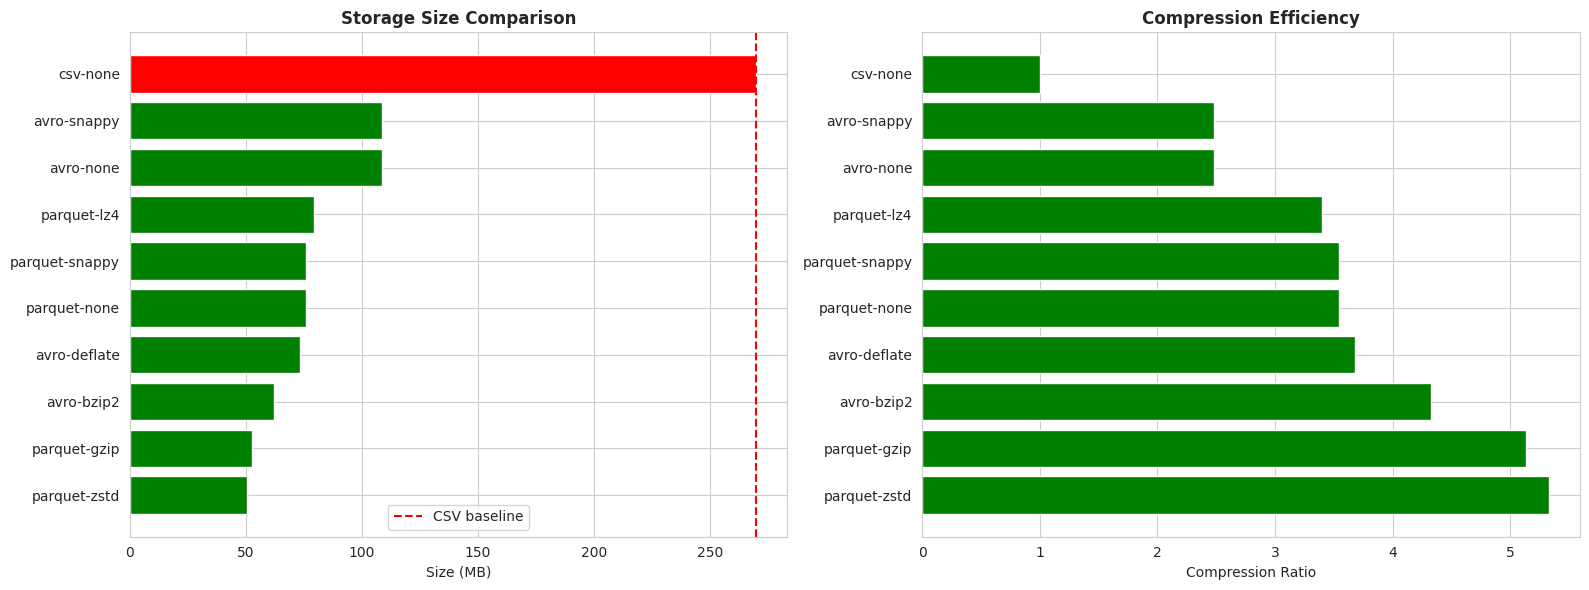


Chart 2: Write Performance


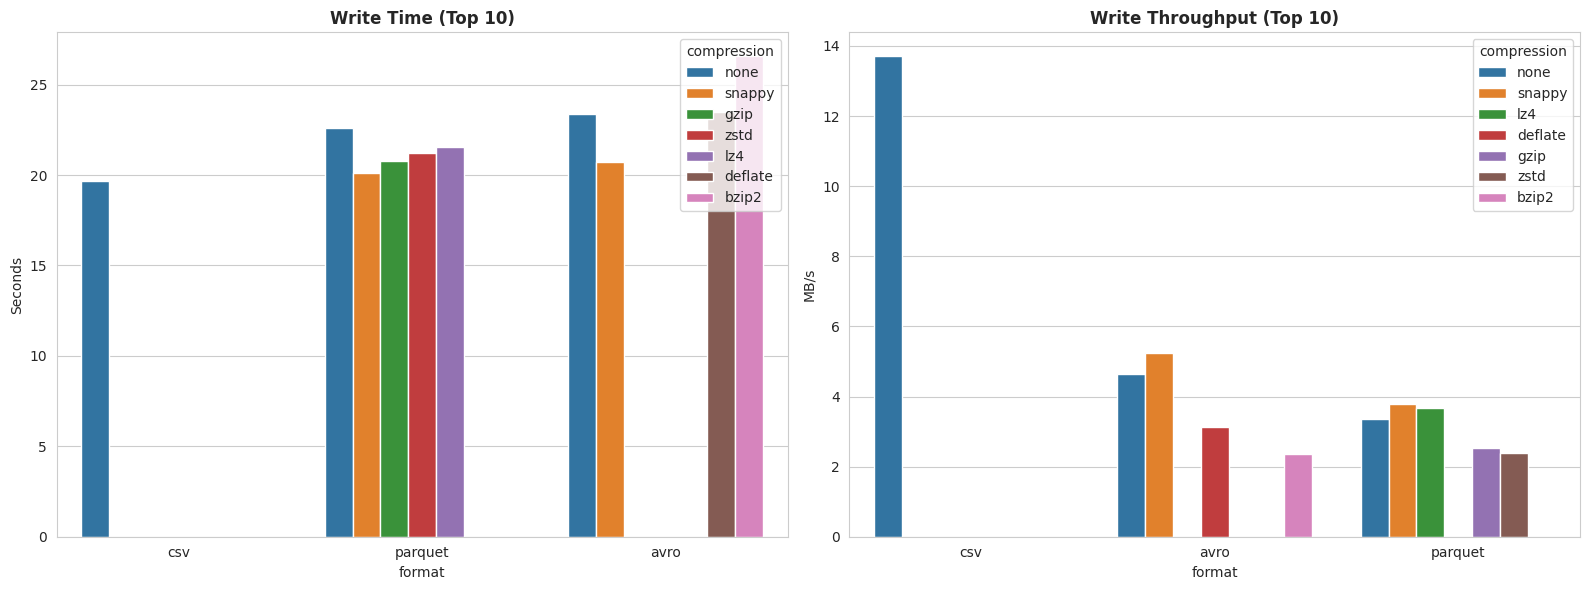


Chart 3: Read Performance


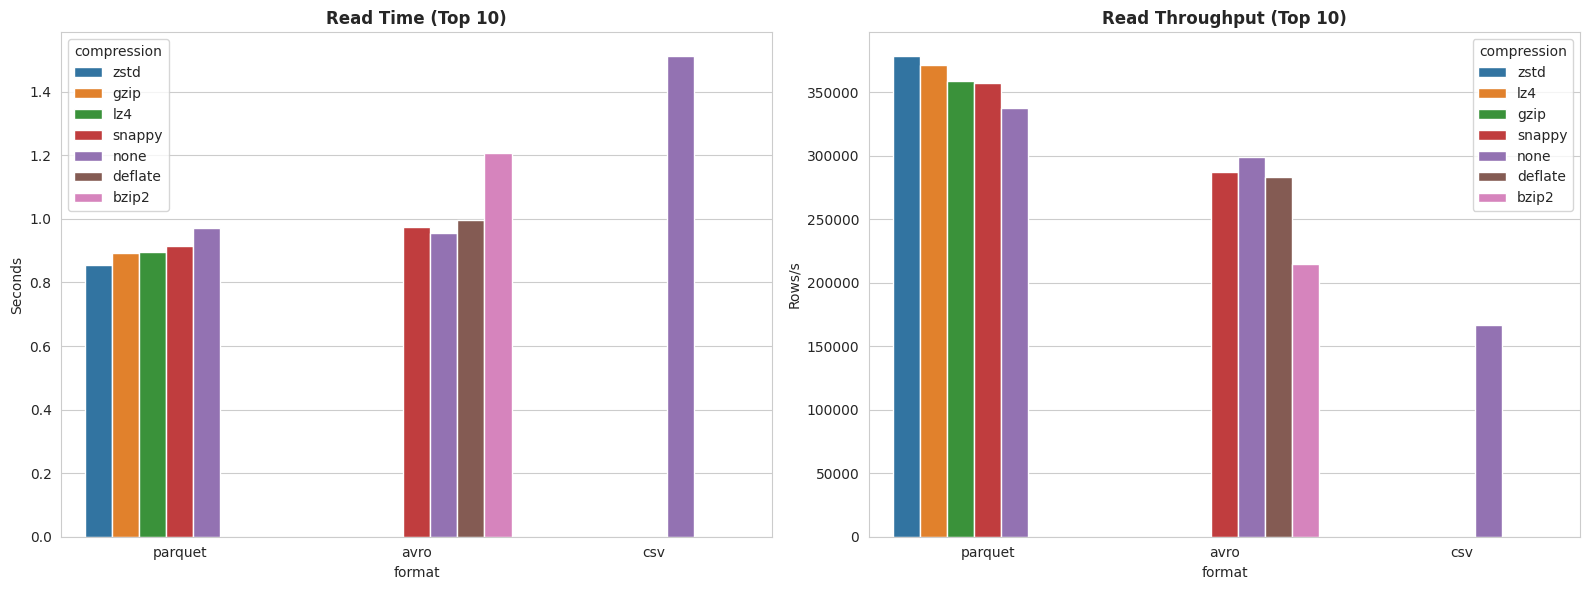

In [0]:
sns.set_style("whitegrid")

# Chart 1: Storage
print("\nChart 1: Storage Comparison")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
top15 = storage.sort_values('size_mb').tail(15)
colors = ['red' if x == 'csv' else 'green' for x in top15['format']]
ax1.barh(range(len(top15)), top15['size_mb'], color=colors)
ax1.set_yticks(range(len(top15)))
ax1.set_yticklabels([f"{r['format']}-{r['compression']}" for _, r in top15.iterrows()])
ax1.set_xlabel('Size (MB)')
ax1.set_title('Storage Size Comparison', fontweight='bold')
ax1.axvline(x=csv_size, color='red', linestyle='--', label='CSV baseline')
ax1.legend()

ax2 = axes[1]
top15_r = storage.sort_values('compression_ratio', ascending=False).head(15)
ax2.barh(range(len(top15_r)), top15_r['compression_ratio'], color='green')
ax2.set_yticks(range(len(top15_r)))
ax2.set_yticklabels([f"{r['format']}-{r['compression']}" for _, r in top15_r.iterrows()])
ax2.set_xlabel('Compression Ratio')
ax2.set_title('Compression Efficiency', fontweight='bold')

plt.tight_layout()
display(fig) 
plt.close()

# Chart 2: Write Performance
print("\nChart 2: Write Performance")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
sns.barplot(data=write_summary.head(10), x='format', y='write_time_seconds', hue='compression', ax=ax1)
ax1.set_title('Write Time (Top 10)', fontweight='bold')
ax1.set_ylabel('Seconds')

ax2 = axes[1]
top10_tp = write_summary.sort_values('throughput', ascending=False).head(10)
sns.barplot(data=top10_tp, x='format', y='throughput', hue='compression', ax=ax2)
ax2.set_title('Write Throughput (Top 10)', fontweight='bold')
ax2.set_ylabel('MB/s')

plt.tight_layout()
display(fig)  
plt.close()

# Chart 3: Read Performance
print("\nChart 3: Read Performance")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
sns.barplot(data=read_summary.head(10), x='format', y='read_time_seconds', hue='compression', ax=ax1)
ax1.set_title('Read Time (Top 10)', fontweight='bold')
ax1.set_ylabel('Seconds')

ax2 = axes[1]
read_with_tp = read_pd[read_pd['query_type'] == 'full_scan'].copy()
read_with_tp['throughput'] = read_with_tp['rows_read'] / read_with_tp['read_time_seconds']
top10_read = read_with_tp.groupby(['format', 'compression'])['throughput'].mean().reset_index().nlargest(10, 'throughput')
sns.barplot(data=top10_read, x='format', y='throughput', hue='compression', ax=ax2)
ax2.set_title('Read Throughput (Top 10)', fontweight='bold')
ax2.set_ylabel('Rows/s')

plt.tight_layout()
display(fig)  
plt.close()

---
# 6. Final Report

## 6.1 Generate Markdown Report

In [0]:

print("\n" + "="*100)
print("GENERATING FINAL REPORT")
print("="*100)

# Generate report
report = f"""# TransferMarkt Data Warehouse - Benchmark Report

**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Platform**: Databricks Serverless + Unity Catalog  
**Author**: Ali Adel

---

## Executive Summary

🏆 **Winner**: {w_format} with {w_comp} compression

**Performance:**
- Overall Score: {w_score:.1f}/100
- Compression Ratio: {w_ratio:.2f}x
- Space Saved: {float(winner['space_saved_percent']):.1f}%

---

## Results Summary

### Storage (Top 10)

{storage[['format', 'compression', 'size_mb', 'compression_ratio', 'space_saved_percent']].head(10).to_markdown(index=False)}

### Write Performance (Top 10)

{write_summary[['format', 'compression', 'write_time_seconds', 'throughput']].head(10).to_markdown(index=False)}

### Read Performance (Top 10)

{read_summary[['format', 'compression', 'read_time_seconds']].head(10).to_markdown(index=False)}

---

## Recommendations

- **Analytics/BI**: Parquet + Snappy (best read performance)
- **Streaming/ETL**: Avro + Snappy (schema evolution)
- **Archival**: Parquet + ZSTD (maximum compression)
- **General Purpose**: Parquet + Snappy (best balance)

---

*Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}*
"""

# Display report in notebook
print("\n" + "="*100)
print(report)
print("="*100)

print("\n✅ Final report generated and displayed")
print("   Note: Copy the text above to save as .md file if needed")


GENERATING FINAL REPORT

# TransferMarkt Data Warehouse - Benchmark Report

**Date**: 2026-02-08 09:29:24  
**Platform**: Databricks Serverless + Unity Catalog  
**Author**: Ali Adel

---

## Executive Summary

🏆 **Winner**: PARQUET with ZSTD compression

**Performance:**
- Overall Score: 302.3/100
- Compression Ratio: 5.33x
- Space Saved: 81.2%

---

## Results Summary

### Storage (Top 10)

| format   | compression   |   size_mb |   compression_ratio |   space_saved_percent |
|:---------|:--------------|----------:|--------------------:|----------------------:|
| parquet  | zstd          |     50.67 |             5.32662 |               81.2264 |
| parquet  | gzip          |     52.56 |             5.13508 |               80.5261 |
| avro     | bzip2         |     62.37 |             4.3274  |               76.8914 |
| avro     | deflate       |     73.37 |             3.67862 |               72.8159 |
| parquet  | none          |     76.13 |             3.54525 |               71.7

## 6.2 Project Summary

---
# 7. Built with ❤